In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

df = pd.read_csv('sales_data_(hyundai,shinsegae).csv')

#연매출비교
dfsaleyear = df.groupby(['year', 'mandata_brand_name'])['sales_all_year'].first().reset_index()
total_sales_by_year = dfsaleyear.groupby('year')['sales_all_year'].transform('sum')
dfsaleyear['yearly_ratio'] = dfsaleyear['sales_all_year'] / total_sales_by_year
yearly_ratio = dfsaleyear.copy()
yearly_ratio['year'] += 1

#월매출비교
dfsalemon = df.groupby(['year', 'mon', 'mandata_brand_name'])['sales_all_month'].sum().reset_index()
total_sales_by_mon_year = dfsalemon.groupby(['mon', 'year'])['sales_all_month'].sum()
dfsalemon['monthly_ratio'] = dfsalemon.apply(lambda row: row['sales_all_month'] / total_sales_by_mon_year.loc[(row['mon'], row['year'])], axis=1)
monthly_ratio = dfsalemon.copy()

In [2]:
def my_strategy(row):
    year = row['year']
    mon = row['mon']
    name = row['mandata_brand_name']
    
    # 연도와 월, 그리고 기업에 해당하는 연도별 비율을 가져옵니다.
    yearly_ratio_value = yearly_ratio[(yearly_ratio['year'] == year) & (yearly_ratio['mandata_brand_name'] == name)]['yearly_ratio'].values
    # 연도와 월, 그리고 기업에 해당하는 월별 비율을 가져옵니다.
    monthly_ratio_value = monthly_ratio[(monthly_ratio['year'] == year) & (monthly_ratio['mon'] == mon) & (monthly_ratio['mandata_brand_name'] == name)]['monthly_ratio'].values
    
    # 연도별 비율과 월별 비율이 모두 존재하는지 확인
    if yearly_ratio_value.size > 0 and monthly_ratio_value.size > 0:
        # 월별 비율이 연도별 비율보다 높으면 매수
        if monthly_ratio_value[0] > yearly_ratio_value[0]:
            return 'buy'
        # 월별 비율이 연도별 비율보다 낮으면 매도
        elif monthly_ratio_value[0] < yearly_ratio_value[0]:
            return 'sell'
        # 비율이 같으면 보유
        else:
            return 'hold'
    else:
        # 데이터가 없는 경우
        return 'no data'

# apply 메서드를 사용하여 새로운 열을 생성합니다.
monthly_ratio['active'] = monthly_ratio.apply(my_strategy, axis=1)
monthly_ratio

monthly_ratio = monthly_ratio[monthly_ratio['active'] != 'no data']
sell_previous = monthly_ratio[monthly_ratio['active'] == 'buy']
sell_current = monthly_ratio[monthly_ratio['active'] == 'sell']
merged = sell_current.merge(sell_previous, how='outer', indicator=True)
changed_rows = merged[merged['_merge'] == 'right_only']
result = changed_rows.drop(columns=['_merge'])

In [3]:
import pandas as pd

def find_changed_rows(result, mandata_brand_name):
    changed_rows = result[result[mandata_brand_name] != result[mandata_brand_name].shift()]
    
    return changed_rows

changed_name_rows = find_changed_rows(result, 'mandata_brand_name')

In [4]:
changed_name_rows = changed_name_rows.copy()  # 데이터프레임의 복사본 생성
changed_name_rows['date'] = pd.to_datetime(changed_name_rows['year'].astype(str) + '-' + changed_name_rows['mon'].astype(str))
changed_name_rows['date'] = changed_name_rows['date'] + pd.offsets.BMonthEnd()
changed_name_rows['date'] = pd.to_datetime(changed_name_rows['date'])
changed_name_rows.at[65, 'date'] = '2021-12-30'
changed_name_rows

,year,mon,mandata_brand_name,sales_all_month,monthly_ratio,active,date
42,2020,1,SHINSEGAE INC_ALL,2.963949e+10,0.592182,buy,2020-01-31
43,2020,2,HYUNDAI DEPARTMENT STORE CO LTD_ALL,1.331284e+10,0.433534,buy,2020-02-28
54,2021,1,SHINSEGAE INC_ALL,5.424035e+10,0.620815,buy,2021-01-29
56,2021,3,HYUNDAI DEPARTMENT STORE CO LTD_ALL,4.104488e+10,0.496055,buy,2021-03-31
61,2021,8,SHINSEGAE INC_ALL,4.340407e+10,0.557773,buy,2021-08-31
63,2021,10,HYUNDAI DEPARTMENT STORE CO LTD_ALL,4.552625e+10,0.477472,buy,2021-10-29
65,2021,12,SHINSEGAE INC_ALL,6.572312e+10,0.581486,buy,2021-12-30
79,2023,2,HYUNDAI DEPARTMENT STORE CO LTD_ALL,3.886191e+10,0.429560,buy,2023-02-28
81,2023,4,SHINSEGAE INC_ALL,6.393854e+10,0.604905,buy,2023-04-28
83,2023,6,HYUNDAI DEPARTMENT STORE CO LTD_ALL,4.354291e+10,0.430442,buy,2023-06-30


In [5]:
from collections import defaultdict

In [6]:
close_hs = pd.read_csv('stock_data_(hyundai,shinsegae).csv', parse_dates=['transaction_date'])
s_close = pd.read_csv('s_close.csv', parse_dates=['transaction_date'])

In [7]:
buy_dates = []
sell_dates = []

# 마지막 매도일 설정
last_sell_date = '2023-07-31'

for i in range(len(changed_name_rows) - 1):  # 마지막 값은 제외
    buy_date = changed_name_rows.iloc[i]['date']
    sell_date = changed_name_rows.iloc[i + 1]['date']
    buy_dates.append(buy_date)  # 매수 날짜를 buy_dates 리스트에 추가
    sell_dates.append(sell_date)  # 매도 날짜를 sell_dates 리스트에 추가

# changed_name_rows의 마지막 행에 해당하는 매수 날짜를 buy_dates 리스트에 추가
last_buy_date = changed_name_rows.iloc[-1]['date']
buy_dates.append(last_buy_date)

# sell_dates 리스트에서 마지막 값을 제거하고 last_sell_date를 추가
sell_dates.append(last_sell_date)  # last_sell_date를 추가

In [8]:
buy_dates

[Timestamp('2020-01-31 00:00:00'),
 Timestamp('2020-02-28 00:00:00'),
 Timestamp('2021-01-29 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2021-08-31 00:00:00'),
 Timestamp('2021-10-29 00:00:00'),
 Timestamp('2021-12-30 00:00:00'),
 Timestamp('2023-02-28 00:00:00'),
 Timestamp('2023-04-28 00:00:00'),
 Timestamp('2023-06-30 00:00:00')]

In [9]:
sell_dates

[Timestamp('2020-02-28 00:00:00'),
 Timestamp('2021-01-29 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2021-08-31 00:00:00'),
 Timestamp('2021-10-29 00:00:00'),
 Timestamp('2021-12-30 00:00:00'),
 Timestamp('2023-02-28 00:00:00'),
 Timestamp('2023-04-28 00:00:00'),
 Timestamp('2023-06-30 00:00:00'),
 '2023-07-31']

In [49]:
buy_dates = []
sell_dates = []

# 마지막 매도일 설정
last_sell_date = '2023-07-31'

for i in range(len(changed_name_rows) - 1):  # 마지막 값은 제외
    buy_date = changed_name_rows.iloc[i]['date']
    sell_date = changed_name_rows.iloc[i + 1]['date']
    buy_dates.append(buy_date)  # 매수 날짜를 buy_dates 리스트에 추가
    sell_dates.append(sell_date)  # 매도 날짜를 sell_dates 리스트에 추가

# changed_name_rows의 마지막 행에 해당하는 매수 날짜를 buy_dates 리스트에 추가
last_buy_date = changed_name_rows.iloc[-1]['date']
buy_dates.append(last_buy_date)

# sell_dates 리스트에서 마지막 값을 제거하고 last_sell_date를 추가
sell_dates.append(last_sell_date)  # last_sell_date를 추가

# 수익률 계산을 위한 함수 정의
def calculate_profit(buy_price, sell_price):
    return (sell_price - buy_price) / buy_price * 100

def combine_profits(profit_h, profit_s, is_long_position):
    if is_long_position:
        return - profit_h + profit_s
    else:
        return - profit_s + profit_h

# 누적 수익률을 계산하는 함수 정의
def calculate_cumulative_profits(buy_dates, sell_dates, close_hs):
    cumulative_profits = []
    is_long_position = True
    previous_profit = 0  # 이전 누적 수익률

    for i in range(len(buy_dates)):
        buy_date = buy_dates[i]
        sell_date = sell_dates[i]

        buy_price_h = close_hs[close_hs['transaction_date'] == buy_date]['Close_h'].values
        sell_price_h = close_hs[close_hs['transaction_date'] == sell_date]['Close_h'].values
        buy_price_s = close_hs[close_hs['transaction_date'] == buy_date]['Close_s'].values
        sell_price_s = close_hs[close_hs['transaction_date'] == sell_date]['Close_s'].values


        buy_price_h = buy_price_h[0]
        sell_price_h = sell_price_h[0]
        buy_price_s = buy_price_s[0]
        sell_price_s = sell_price_s[0]

        profit_h = calculate_long_profit(buy_price_h, sell_price_h)
        profit_s = calculate_long_profit(buy_price_s, sell_price_s)
        combined_profit = combine_profits(profit_h, profit_s, is_long_position)

        # 현재 누적 수익률 계산
        current_profit = previous_profit + combined_profit
        cumulative_profits.append(current_profit)

        # 현재 누적 수익률을 이전 누적 수익률로 업데이트
        previous_profit = current_profit

        # 롱 포지션과 숏 포지션을 번갈아가며 거래
        is_long_position = not is_long_position

    return cumulative_profits

# 누적 수익률 계산
cumulative_profits = calculate_cumulative_profits(buy_dates, sell_dates, close_hs)

# 구간별 수익률 출력
for i, profit in enumerate(cumulative_profits):
    print(f"구간 {i+1} 누적 수익률: {profit:.2f}%")


구간 1 누적 수익률: -2.51%
구간 2 누적 수익률: 8.85%
구간 3 누적 수익률: 13.21%
구간 4 누적 수익률: 6.56%
구간 5 누적 수익률: -3.72%
구간 6 누적 수익률: -15.44%
구간 7 누적 수익률: -7.43%
구간 8 누적 수익률: -13.20%
구간 9 누적 수익률: -22.10%
구간 10 누적 수익률: -17.08%


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

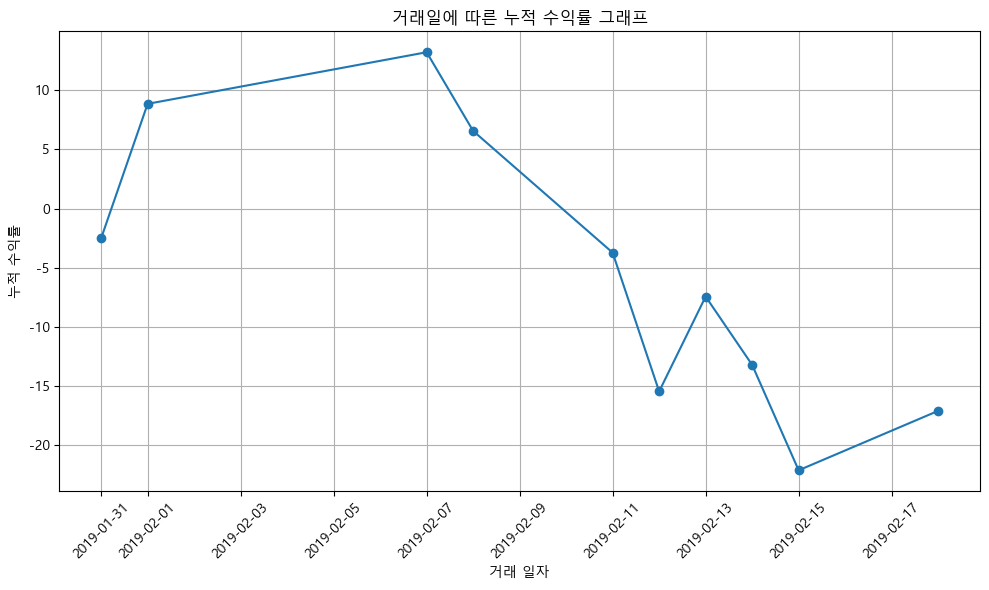

In [39]:
import matplotlib.pyplot as plt

# 거래일에 따른 누적 수익률 그래프를 그리는 함수
def plot_cumulative_profit(buy_dates, sell_dates, close_hs):
    cumulative_profits = []
    is_long_position = True
    previous_profit = 0  # 이전 누적 수익률

    # buy와 sell 중 긴 쪽의 길이를 기준으로 순회
    max_length = max(len(buy_dates), len(sell_dates))
    for i in range(max_length):

            buy_price_h = close_hs[close_hs['transaction_date'] == buy_date]['Close_h'].values[0]
            buy_price_s = close_hs[close_hs['transaction_date'] == buy_date]['Close_s'].values[0]
        if i < len(sell_dates):
            sell_date = sell_dates[i]
            sell_price_h = close_hs[close_hs['transaction_date'] == sell_date]['Close_h'].values[0]
            sell_price_s = close_hs[close_hs['transaction_date'] == sell_date]['Close_s'].values[0]

            profit_h = calculate_long_profit(buy_price_h, sell_price_h)
            profit_s = calculate_long_profit(buy_price_s, sell_price_s)
            combined_profit = combine_profits(profit_h, profit_s, is_long_position)

            # 현재 누적 수익률 계산
            current_profit = previous_profit + combined_profit
            cumulative_profits.append(current_profit)

            # 현재 누적 수익률을 이전 누적 수익률로 업데이트
            previous_profit = current_profit

            # 롱 포지션과 숏 포지션을 번갈아가며 거래
            is_long_position = not is_long_position

    # 거래일자를 x축으로, 누적 수익률을 y축으로 하는 그래프 그리기
    plt.figure(figsize=(10, 6))
    plt.plot(close_hs['transaction_date'][:len(cumulative_profits)], cumulative_profits, marker='o', linestyle='-')
    plt.title('거래일에 따른 누적 수익률 그래프')
    plt.xlabel('거래 일자')
    plt.ylabel('누적 수익률')
    plt.grid(True)
    plt.xticks(rotation=45)  # x축 라벨 회전
    plt.tight_layout()

    # 그래프 출력
    plt.show()

# 함수를 호출하여 누적 수익률 그래프 출력
plot_cumulative_profit(buy_dates, sell_dates, close_hs)


In [30]:
# 파일을 구간별로 나누어 그래프 그리기
plt.figure(figsize=(12, 6))
start_index = 0
colors = {'Hyundai Long': 'royalblue', 'Shinsegae Long': 'green'}  # 각 타입에 대한 색상 지정
plt.plot(close_hs['transaction_date'], current_profit, color=colors[type_name], marker='o')

# 범주 추가
plt.legend(title='Type', loc='upper left', labels=list(reversed(sorted(colors.keys()))))  # 롯데 롱이 먼저 표시되도록 범주를 역순으로 정렬하여 표시

plt.xlabel('Date')
plt.ylabel('NAV')
plt.title('현대백화점 신세계 카드사 비교 수익률 그래프')
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'current_profit' is not defined

<Figure size 1200x600 with 0 Axes>

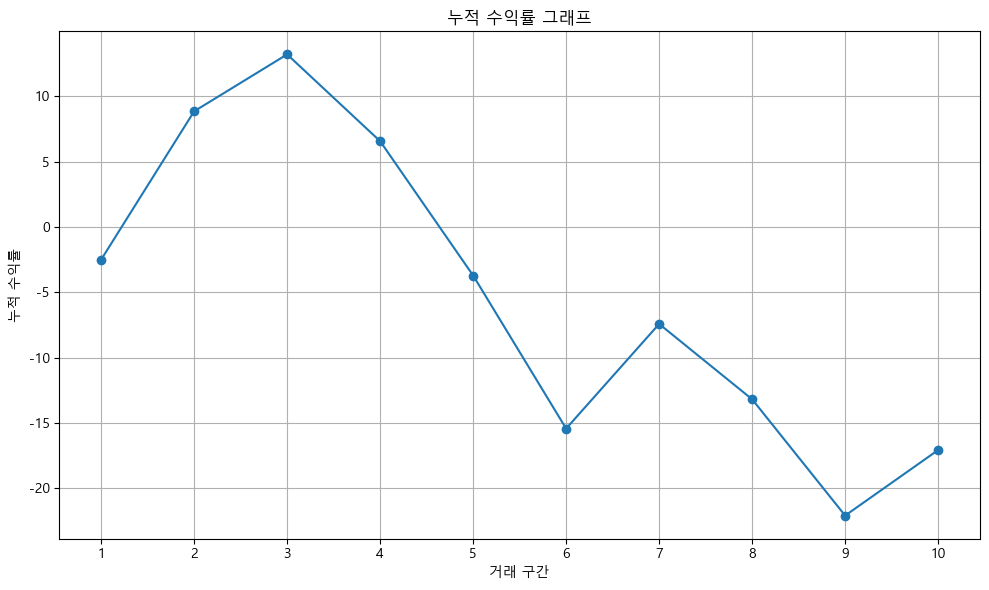

In [23]:
import matplotlib.pyplot as plt

# 거래 구간과 누적 수익률 계산
trade_periods = range(1, len(cumulative_profits) + 1)
cumulative_profits_values = cumulative_profits

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(trade_periods, cumulative_profits_values, marker='o', linestyle='-')
plt.title('누적 수익률 그래프')
plt.xlabel('거래 구간')
plt.ylabel('누적 수익률')
plt.grid(True)
plt.xticks(trade_periods)
plt.tight_layout()

# 그래프 출력
plt.show()


In [71]:
profit_h

7.156673114119923

In [ ]:
profit_s

In [1]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import talib
from datetime import timedelta, datetime
from warnings import filterwarnings
filterwarnings('ignore')

df_origin = pd.DataFrame()

#코스피와 코스닥 데이터만 갖고온다. 코넥스 제외
m = ['KOSDAQ', 'KOSPI']
for i in m:
    tmp = fdr.StockListing(i)
    df_origin = pd.concat([df_origin, tmp], axis=0)

df_origin.dropna(inplace=True)
symbols = df_origin.Code
markets = df_origin.Market
names = df_origin.Name

In [4]:
# 2일전과 1일전 20일선 데이터가 60일선 데이터보다 작았으면서, && 현재 20일선 데이터가 60일선보다 클 때
golden_cross = []
for i in range(2, len(삼성전자_데이터)-1):
    # 이해를 위해 이번에도 한글로 (원래는 이러면 안됨)
    이틀전20일 = 삼성전자_데이터['ma_20'].iloc[i-2]
    하루전20일 = 삼성전자_데이터['ma_20'].iloc[i-1]
    당일20일 = 삼성전자_데이터['ma_20'].iloc[i]

    이틀전60일 = 삼성전자_데이터['ma_60'].iloc[i-2]
    하루전60일 = 삼성전자_데이터['ma_60'].iloc[i-1]
    당일60일 = 삼성전자_데이터['ma_60'].iloc[i]
    # 위 조건 맞을경우 해당되는 날짜의 번호를 가져감
    if (이틀전20일 < 이틀전60일) and (하루전20일 < 하루전60일) and (당일20일 >= 당일60일):
        golden_cross.append(i)
    # 그러지 않을 경우 되돌아간다 = continue
    else:
        continue

# 가져간 번호 날짜를 출력
삼성전자_데이터_골든크로스 = 삼성전자_데이터.loc[golden_cross]
print(f'골든크로스는 얼마나 나왔을까? : {len(삼성전자_데이터_골든크로스)} 번 만큼!', )
삼성전자_데이터_골든크로스

NameError: name '삼성전자_데이터' is not defined

#### 수익률 확인
- 5% 상승 시 손익
- 5% 하락 시 손절

In [11]:
from collections import defaultdict

# 결과물을 담을 dictionary
# 손익 시 1 손절 시 0으로 구별한다
result = defaultdict(int)

삼성전자_데이터_골든크로스_검증용 = 삼성전자_데이터_골든크로스.reset_index().rename(columns = {'index' : 'golden'})
for i in range(len(삼성전자_데이터_골든크로스_검증용)):
    
    # 각각 골든크로스 구간마다 진입한다고 가정하는 tmp 변수
    tmp = 삼성전자_데이터.iloc[삼성전자_데이터_골든크로스_검증용['golden'].iloc[i]:]
    
    # 진입 시점 종가 가격
    tmp_close = 삼성전자_데이터_골든크로스_검증용['Close'].iloc[i]
    for j in range(1, len(tmp)):
        tmp_income = (tmp['Close'].iloc[j] - tmp_close) / tmp_close * 100
        # 5%가 넘거나 -5% 수익이면 해당 반복문 break 후 마무리
        if tmp_income >= 5:
            result[삼성전자_데이터_골든크로스_검증용['Date'].iloc[i]] = 1
            break

        elif tmp_income <= -5:
            result[삼성전자_데이터_골든크로스_검증용['Date'].iloc[i]] = 0
            break     


win = len(dict(filter(lambda elem:elem[1]==1, result.items())))
loss = len(dict(filter(lambda elem:elem[1]==0, result.items())))

print(f'삼성전자의 골든크로스 win 횟수: {win}, loss 횟수: {loss}   승률은!? : {(win / len(result)) * 100}%')

삼성전자의 골든크로스 win 횟수: 29, loss 횟수: 26   승률은!? : 52.72727272727272%


In [12]:
삼성전자_데이터_골든크로스

,Date,Open,High,Low,Close,Volume,Change,ma_20,ma_60
23,2000-03-23,6480,6580,6200,6200,1299012,0.000000,5547.0,5543.833333
203,2000-12-18,3500,3590,3489,3560,687058,0.020057,3378.0,3376.500000
281,2001-04-19,4620,4919,4580,4700,2626128,0.098131,4024.5,4006.500000
369,2001-08-27,3960,4020,3920,3980,759108,0.036458,3851.5,3844.833333
418,2001-11-07,3820,3829,3770,3810,885396,0.002632,3490.0,3489.000000
626,2002-09-13,6730,6739,6630,6630,478466,-0.033528,6687.0,6677.166667
662,2002-11-06,7360,7370,7230,7310,655035,0.011065,6552.0,6510.500000
766,2003-04-08,5840,6030,5820,5980,808535,0.000000,5921.5,5903.833333
897,2003-10-22,9300,9420,9150,9400,589650,0.017316,8576.0,8564.666667
955,2004-01-15,9900,10000,9810,9930,632553,0.004044,9250.5,9232.500000


In [16]:
import datetime
import backtrader as bt
import yfinance as yf


class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        if self.dataclose[0] < self.dataclose[-1]:
            # current close less than previous close

            if self.dataclose[-1] < self.dataclose[-2]:
                # previous close less than the previous close

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buy()

cerebro=bt.Cerebro()

data = yf.download('036570.KS', start='2017-01-01', end='2019-12-01')
feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(feed)
cerebro.addstrategy(TestStrategy)
cerebro.broker.setcash(10000000)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot(iplot=False)

[*********************100%%**********************]  1 of 1 completed


Starting Portfolio Value: 10000000.00
2017-01-02, Close, 248000.00
2017-01-02, BUY CREATE, 248000.00
2017-01-03, Close, 259000.00
2017-01-04, Close, 260000.00
2017-01-05, Close, 261000.00
2017-01-06, Close, 260500.00
2017-01-09, Close, 262000.00
2017-01-10, Close, 263500.00
2017-01-11, Close, 267500.00
2017-01-12, Close, 277000.00
2017-01-13, Close, 279500.00
2017-01-16, Close, 287000.00
2017-01-17, Close, 281000.00
2017-01-18, Close, 286500.00
2017-01-19, Close, 300000.00
2017-01-20, Close, 314000.00
2017-01-23, Close, 313000.00
2017-01-24, Close, 304500.00
2017-01-24, BUY CREATE, 304500.00
2017-01-25, Close, 305500.00
2017-01-26, Close, 308500.00
2017-01-31, Close, 304000.00
2017-02-01, Close, 307000.00
2017-02-02, Close, 306500.00
2017-02-03, Close, 316000.00
2017-02-06, Close, 316000.00
2017-02-07, Close, 301000.00
2017-02-08, Close, 302000.00
2017-02-09, Close, 293500.00
2017-02-10, Close, 292500.00
2017-02-10, BUY CREATE, 292500.00
2017-02-13, Close, 294000.00
2017-02-14, Close, 

KeyboardInterrupt: 

In [ ]:
import datetime
import backtrader as bt
import yfinance as yf


class TestStrategy(bt.Strategy):
    
    params = (
        ('sma1', 5),
        ('sma2', 20),
        )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        self.sma1 = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.sma1)
        self.sma2 = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.sma2)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.sma1[0] > self.sma2[0]:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if self.sma1[0] < self.sma2[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

cerebro=bt.Cerebro()

data = yf.download('005930.KS', start='2020-01-01', end='2023-07-07')
feed = bt.feeds.PandasData(dataname=data)
cerebro.adddata(feed)
cerebro.addstrategy(TestStrategy)
cerebro.broker.setcash(10000000)
cerebro.broker.setcommission(commission=0.0015)
cerebro.addsizer(bt.sizers.FixedSize, stake=10)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot(iplot=False)
bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
bt.indicators.WeightedMovingAverage(self.datas[0], period=25).subplot = True
bt.indicators.StochasticSlow(self.datas[0])
bt.indicators.MACDHisto(self.datas[0])
rsi = bt.indicators.RSI(self.datas[0])
bt.indicators.SmoothedMovingAverage(rsi, period=10)
bt.indicators.ATR(self.datas[0]).plot = False